本文件是使用functions读取TerraSAR-X数据的示例

In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from glob import glob
import matplotlib.pyplot as plt
from functions.dem import WorldDEM, Egm,Coord,SRTM
from functions.image import TX, wgs2ecs, ecs2wgs
from functions.dem import wgs2utm, utm2wgs
from functions.wrf import Wrf
import numpy as np
import pandas as pd

# 显示中文
def get_font_name(index=0):
    with os.popen('fc-list :lang=zh') as f:
        fonts = f.readlines()
        font_name = fonts[index].split(": ")[1].split(",")[1]
        return font_name

plt.rcParams['font.sans-serif'] = get_font_name()

使用`get_tx_paths`来根据日期搜索影像路径

In [2]:
def get_tx_paths():
    xml_paths = glob(
        "data/TerraSAR-X/*/TSX-1.SAR.L1B/*/*SAR__SSC*.xml")
    res = {}
    for i in xml_paths:
        filename = i.split("/")[-1][:-4]
        res[filename[28:36]] = ((i, glob(
            "data/TerraSAR-X/*/TSX-1.SAR.L1B/%s/IMAGEDATA/*.cos" % filename)[0]))
    return res

csv_path = "data/points.csv"
egm96_path = "data/EGM/EGM96.tif"
egm2008_path = "data/EGM/EGM2008.tif"
srtm_path = "data/SRTM/SRTMGL1/N40E116.hgt"
worlddem_path = "data/WorldDEM/SO_000117371_0001_1/WorldDEM_DSM_04_N40_16_E116_20/DEM/WorldDEM_DSM_04_N40_16_E116_20_DEM.tif"
sDay = "20190117"
wrf_path = glob("data/wrf/%s-%s-%s*" % (sDay[:4], sDay[4:6], sDay[6:8]))[0]

`single`函数对单个点(lon, lat)进行定位，截取目标附近65m x 65m的区域，分辨率为1m。

wrf是用于对流层校正的对象，若没有相关数据，可以传入0；

dem是用于获取高程的对象，若没有相关数据，可以传入0；

由于电离层影响太小，所以未实现电离层校正的代码，用0代替。

In [3]:
def single(img, lon, lat, wrf=0, dem=0, ion=0, length=32, step=1):
    x, y = wgs2utm(lon, lat)
    extent = np.arange(-length, length+1, step=step)
    xs, ys = np.meshgrid(extent+x, extent+y)
    lon, lat = utm2wgs(xs, ys)

    if isinstance(dem, int) or isinstance(dem, float):
        h = dem * np.ones(lon.shape)
    else:
        h = dem.find(lon, lat, Coord.WGS84)    

    gen = img.indirect_with_offset(lon, lat, h)
    sp = gen.send(None)

    if isinstance(wrf, int) or isinstance(wrf, float):
        offset, coe, cons = np.zeros(np.shape(lon)), 1, 0
    else:
        offset, coe, cons = wrf.cal_delays(sp, lon, lat, h)

    if isinstance(ion, int) or isinstance(ion, float):
        cons += 0
    else:
        raise ValueError("未编写电离层校正程序")
        
    rows, cols = gen.send(offset / coe + cons)

    data = img.find(rows, cols)
    max_v = np.max(data)
    data = np.reshape(data, data.shape + (1,))
    data = np.repeat(data, 3, 2)

    delta_step = 1
    min_p = int((length-delta_step) / step)
    max_p = int((length+delta_step) / step)
    data[min_p:max_p+1, min_p] = [max_v, 0, 0]
    data[min_p:max_p+1, max_p] = [max_v, 0, 0]
    data[min_p, min_p:max_p+1] = [max_v, 0, 0]
    data[max_p, min_p:max_p+1] = [max_v, 0, 0]

    data = data / max_v
    plt.imshow(data, origin="lower")

    sp, tp = sp[:, 0, 0], wgs2ecs(lon[0, 0], lat[0, 0], h[0, 0])
    tp2 = 2 * tp - sp
    tp2 = ecs2wgs(tp2[0], tp2[1], tp2[2])
    tp2 = wgs2utm(tp2[0], tp2[1])
    tp = wgs2utm(lon[0, 0], lat[0, 0])
    norm = np.linalg.norm((tp2[0] - tp[0], tp2[1] - tp[1]))*2
    x, y = (tp2[0] - tp[0])/norm*length, (tp2[1] - tp[1])/norm*length
    plt.arrow(length/step, length/step, x/step, y/step, color="red",head_width=1)

    plt.axis('off')
    plt.show()

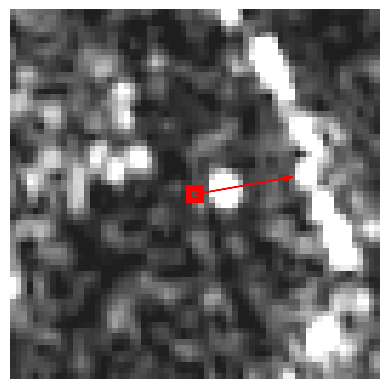

In [4]:
def test_single(sDay, pid):
    xml_path, cos_path = get_tx_paths()[sDay]
    tx = TX(xml_path, cos_path)

    ps = pd.read_csv(csv_path)
    p = ps.loc[ps['id'] == pid].iloc[0]
    lon, lat, h = p['lon'], p['lat'], p['h']
    single(tx, lon, lat, dem=h)

    # # dem = WorldDEM(worlddem_path, Egm(egm2008_path))
    # dem = SRTM(srtm_path,Egm(egm96_path))
    # wrf = Wrf(wrf_path)
    # single(tx, lon, lat, dem=dem, wrf=wrf)

test_single(sDay, 10)

`multi`用于对一组点定位，即lon、lat都是ndarray.

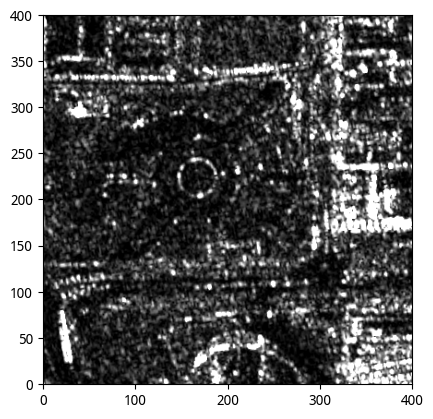

In [5]:
def multi(tx, lon, lat, h):
    rows, cols = tx.indirect(lon, lat, h)
    data = tx.find(rows, cols)
    plt.imshow(data, cmap="gray", origin='lower')
    plt.show()


def test_multi():
    lon, lat, h = 116.2197997, 40.2121041, 56.4
    x, y = wgs2utm(lon, lat)
    extent = np.arange(-200, 201)
    xs, ys = np.meshgrid(extent+x, extent+y)
    lon, lat = utm2wgs(xs, ys)

    xml_path, cos_path = get_tx_paths()[sDay]
    tx = TX(xml_path, cos_path)
    multi(tx, lon, lat, h)


test_multi()

`compare`函数用于比较不同dem带来的差异

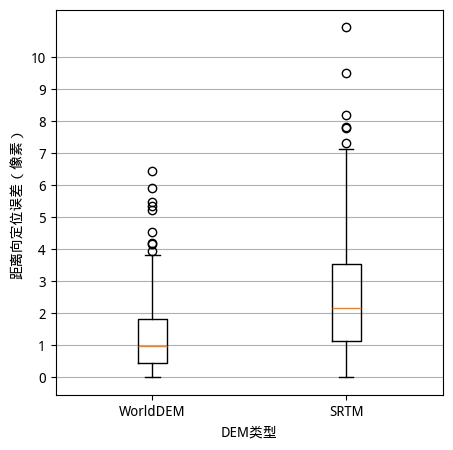

In [6]:
def compare(lon, lat, h1, h2, img:TX):
    r1, c1 = img.indirect(lon, lat, h1)
    r2, c2 = img.indirect(lon, lat, h2)
    return c1 - c2


def test_compare(sDay):
    ps = pd.read_csv(csv_path)
    xml_path, cos_path = get_tx_paths()[sDay]
    tx = TX(xml_path, cos_path)

    worlddem = WorldDEM(worlddem_path, Egm(egm2008_path))
    srtm = SRTM(srtm_path,Egm(egm96_path))

    hw = worlddem.find(ps.lon, ps.lat, Coord.WGS84)
    hs = srtm.find(ps.lon, ps.lat, Coord.WGS84)
    v1 = compare(ps.lon, ps.lat,ps.h,hw,tx)
    v2 = compare(ps.lon, ps.lat,ps.h,hs,tx)
    v3 = compare(ps.lon, ps.lat,hw,hs,tx)

    plt.figure(figsize=(5,5))
    plt.boxplot([np.abs(v1),np.abs(v2)])
    plt.yticks(range(11))
    plt.ylabel("距离向定位误差（像素）")
    plt.xlabel("DEM类型")
    plt.xticks([1,2],["WorldDEM", "SRTM"])
    plt.grid(True, axis="y")

    # plt.scatter(v1, v2,marker=".")
    # plt.xlabel("基于WorldDEM的定位误差（像素）")
    # plt.ylabel("基于SRTM的定位误差（像素）")
    plt.show()


test_compare(sDay)